# **사전작업**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
from torchvision import transforms
from torchvision.models import resnet152
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **데이터셋 클래스 정의**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        # label = self.dataframe.iloc[idx, 1].astype('int64')
        label = torch.tensor(self.dataframe.iloc[idx, 1:].tolist()).argmax().item() # 원-핫 인코딩된 레이블을 정수로 변환

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)


# **데이터 전처리**

In [ ]:
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# **데이터 불러오기**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sinabro/Sinabro_dataset/train/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sinabro/Sinabro_dataset/val/val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sinabro/Sinabro_dataset/test/test.csv')

# **학습 파라미터 설정**

In [ ]:
batch_size = 16
epochs = 25
learning_rate = 0.0001

# **데이터셋 & 데이터로더**

In [ ]:
train_dataset = CustomDataset(train_df, '/content/drive/MyDrive/Colab Notebooks/Sinabro/Sinabro_dataset/train/', transform=transform)
val_dataset = CustomDataset(val_df, '/content/drive/MyDrive/Colab Notebooks/Sinabro/Sinabro_dataset/val/', transform=transform)
test_dataset = CustomDataset(test_df, '/content/drive/MyDrive/Colab Notebooks/Sinabro/Sinabro_dataset/test/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **모델정의**

In [ ]:
model = resnet152(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.3), # Dropout 추가
    nn.Linear(num_features, 3)
)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 92.5MB/s]


# **손실함수 및 옵티마이저**

In [ ]:
criterion = nn.CrossEntropyLoss() # 다중 클래스 분류 손실함수
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001) # weight_decay 매개변수로 L2 정규화 적용
# ReduceLROnPlateau 스케줄러 정의
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# **train / Validation**

In [ ]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
precisions = []
recalls = []
f1_scores = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0 # 이 변수를 사용하여 훈련 손실을 누적
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() # 손실 누적

    # 에포크가 끝날 때 훈련 손실의 평균을 계산
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 검증
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total += labels.size(0)
            _, predicted = torch.max(outputs, 1) # 수정된 부분
            correct += (predicted == labels).sum().item() # 수정된 부분
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # 검증 손실이 이전보다 좋아진 경우 모델 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model_weights.pth')

        # 에포크별 저장
        torch.save(model.state_dict(), f'model_weights_epoch_{epoch+1}.pth')

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {correct/total:.4f}')

        # 스케줄러에 검증 손실 전달
        scheduler.step(avg_val_loss)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)


Epoch [1/25], Train Loss: 0.2116, Validation Loss: 0.1538, Accuracy: 0.9440
Epoch [2/25], Train Loss: 0.1009, Validation Loss: 0.0353, Accuracy: 0.9880
Epoch [3/25], Train Loss: 0.0877, Validation Loss: 0.0419, Accuracy: 0.9900
Epoch [4/25], Train Loss: 0.0862, Validation Loss: 0.0530, Accuracy: 0.9800
Epoch [5/25], Train Loss: 0.0515, Validation Loss: 0.1609, Accuracy: 0.9720
Epoch [6/25], Train Loss: 0.0435, Validation Loss: 0.2152, Accuracy: 0.9740
Epoch [7/25], Train Loss: 0.0379, Validation Loss: 0.0143, Accuracy: 0.9980
Epoch [8/25], Train Loss: 0.0572, Validation Loss: 0.0854, Accuracy: 0.9620
Epoch [9/25], Train Loss: 0.0369, Validation Loss: 0.0464, Accuracy: 0.9880
Epoch [10/25], Train Loss: 0.0200, Validation Loss: 0.0363, Accuracy: 0.9840
Epoch [11/25], Train Loss: 0.0410, Validation Loss: 0.0264, Accuracy: 0.9920
Epoch [12/25], Train Loss: 0.0308, Validation Loss: 0.0167, Accuracy: 0.9940
Epoch [13/25], Train Loss: 0.0255, Validation Loss: 0.0508, Accuracy: 0.9840
Epoch 00

KeyboardInterrupt: ignored

# **test**

In [ ]:
# 모델 불러오기
model_path = '/content/model_weights_epoch_17.pth'
model.load_state_dict(torch.load(model_path))

model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {correct/total:.4f}')

Test Loss: 0.0178, Accuracy: 0.9921


# **학습결과 그래프**

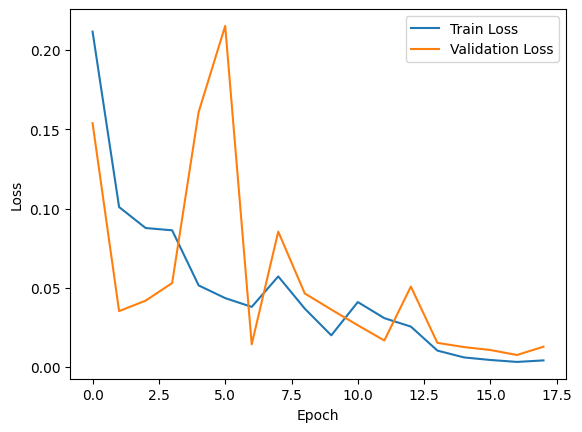

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.xlim(0, 9) # x축의 범위를 0부터 9까지로 설정
plt.legend()
plt.show()


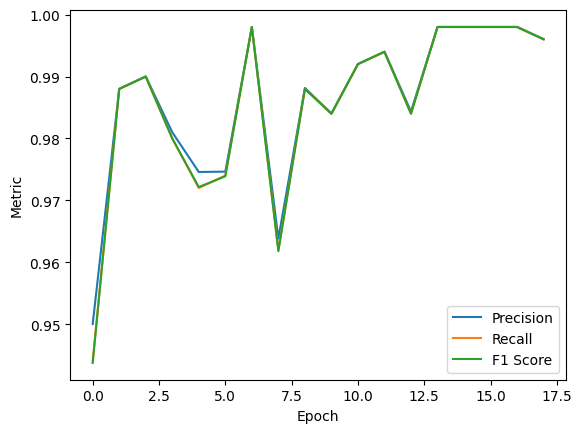

In [ ]:
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.plot(f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
# plt.xlim(0, 9) # x축의 범위를 0부터 9까지로 설정
plt.legend()
plt.show()